<a href="https://colab.research.google.com/github/jainriya9/DeepCamera/blob/master/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DCT

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timm.models.vision_transformer import VisionTransformer
from timm.models.registry import register_model
from timm.models.helpers import load_pretrained

# Define the Vision Transformer model
class CustomVisionTransformer(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super(CustomVisionTransformer, self).__init__(*args, **kwargs)

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        return self.pre_logits(x[:, 0])

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

def apply_dct(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dct = cv2.dct(np.float32(image_gray))
    return dct

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or path is incorrect: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))
    image_normalized = np.array(image_resized) / 255.0
    return image, image_resized, image_normalized


In [ ]:
import torch

# Define the path to the pretrained weights
weights_path = '/content/pvt_v2_b1.pth'

# Load the model
pretrained_model = torch.load(weights_path, map_location='cpu')

# Print the model architecture
print(pretrained_model)


OrderedDict([('patch_embed1.proj.weight', tensor([[[[-4.6990e-03, -2.0338e-03,  9.6846e-03,  ..., -4.3489e-03,
            2.8063e-03,  4.7846e-03],
          [-2.8374e-03, -6.3174e-03,  9.0543e-03,  ..., -2.7097e-02,
            9.6504e-03,  2.3525e-03],
          [-9.3125e-04,  6.2791e-03,  7.4276e-02,  ..., -5.4037e-02,
            2.9517e-03,  3.2785e-03],
          ...,
          [ 3.0961e-03, -1.3980e-02, -8.5256e-02,  ...,  4.5591e-02,
            4.6593e-02, -1.7749e-02],
          [ 8.4478e-03, -1.0028e-02, -3.0605e-02,  ..., -7.9711e-02,
            3.4337e-02,  1.4798e-03],
          [ 6.4268e-03,  3.0332e-03, -3.1863e-02,  ..., -1.4999e-02,
            1.3778e-02, -9.7836e-03]],

         [[-8.2029e-04, -5.3576e-03, -1.5150e-02,  ..., -2.0095e-02,
           -2.9111e-03,  1.2889e-03],
          [-1.8592e-03, -1.6607e-02,  4.2953e-03,  ..., -1.3011e-02,
           -2.5776e-02,  1.2532e-03],
          [-3.6435e-03,  2.8066e-02, -2.5555e-02,  ..., -1.6268e-01,
            1.11

In [ ]:
from transformers import PvtV2ForImageClassification, PvtV2Config

def load_vit_model(weights_path, img_size=224, num_classes=1000):
    config = PvtV2Config(
        image_size=img_size,
        num_channels=3,
        # Add other parameters as needed
    )
    model = PvtV2ForImageClassification(config)

    # Load state dict
    state_dict = torch.load(weights_path, map_location='cpu')

    # Modify state dict keys based on provided output
    new_state_dict = {}
    for key, value in state_dict.items():
        # Modify keys to match the expected model architecture
        if key.startswith('norm'):
            new_key = 'pvt_v2.encoder.layers.0.' + key
        elif key.startswith('head'):
            new_key = 'pvt_v2.head.' + key
        else:
            new_key = key
        new_state_dict[new_key] = value

    # Load modified state dict
    model.load_state_dict(new_state_dict, strict=False)

    return model

# Update the weights path
weights_path = '/content/pvt_v2_b1.pth'
vit_model = load_vit_model(weights_path)


In [ ]:
def prepare_dct_image_for_vit(dct_image):
    # Normalize DCT image to [0, 1] range for ViT model
    dct_image_normalized = cv2.normalize(dct_image, None, 0, 1, cv2.NORM_MINMAX)
    dct_image_normalized = np.stack((dct_image_normalized,) * 3, axis=-1)  # Convert to 3-channel
    dct_image_normalized = cv2.resize(dct_image_normalized, (224, 224))
    dct_image_tensor = transforms.ToTensor()(dct_image_normalized)
    dct_image_tensor = dct_image_tensor.unsqueeze(0)  # Add batch dimension
    return dct_image_tensor

def process_image_with_vit(model, image_path):
    image_original, image_resized, image_normalized = load_and_preprocess_image(image_path)
    dct_image = apply_dct(image_normalized)
    dct_image_tensor = prepare_dct_image_for_vit(dct_image)

    model.eval()
    with torch.no_grad():
        features = model(dct_image_tensor)

    return image_original, image_resized, dct_image, features


In [ ]:
def apply_dct(image):
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    # Convert the grayscale image to 8-bit unsigned integer
    image_gray_uint8 = cv2.convertScaleAbs(image_gray)
    # Apply DCT
    dct = cv2.dct(np.float32(image_gray_uint8))
    return dct

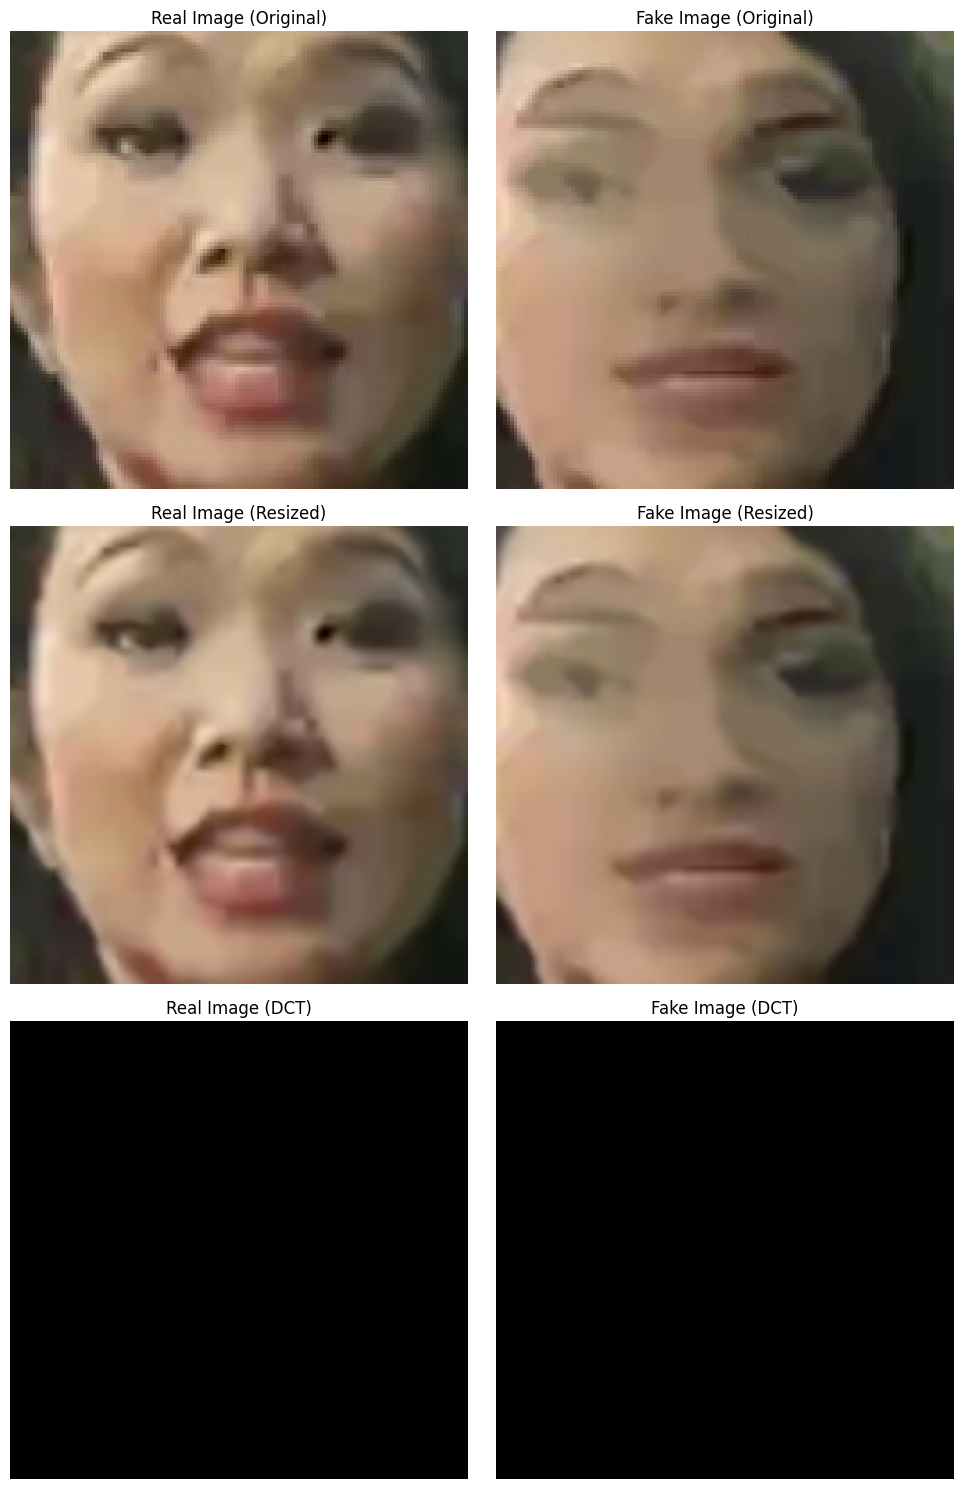

Real Image Features: ImageClassifierOutput(loss=None, logits=tensor([[0., 0.]]), hidden_states=None, attentions=None)
Fake Image Features: ImageClassifierOutput(loss=None, logits=tensor([[0., 0.]]), hidden_states=None, attentions=None)


In [ ]:
real_image_path = '/content/real.jpg'
fake_image_path = '/content/fake.jpg'
weights_path = '/content/pvt_v2_b0.pth'

# Load the ViT model
vit_model = load_vit_model(weights_path)

# Process real image
real_image_original, real_image_resized, real_dct_image, real_features = process_image_with_vit(vit_model, real_image_path)

# Process fake image
fake_image_original, fake_image_resized, fake_dct_image, fake_features = process_image_with_vit(vit_model, fake_image_path)

# Display the images
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes[0, 0].imshow(real_image_original)
axes[0, 0].set_title('Real Image (Original)')
axes[1, 0].imshow(real_image_resized)
axes[1, 0].set_title('Real Image (Resized)')
axes[2, 0].imshow(real_dct_image, cmap='gray')
axes[2, 0].set_title('Real Image (DCT)')

axes[0, 1].imshow(fake_image_original)
axes[0, 1].set_title('Fake Image (Original)')
axes[1, 1].imshow(fake_image_resized)
axes[1, 1].set_title('Fake Image (Resized)')
axes[2, 1].imshow(fake_dct_image, cmap='gray')
axes[2, 1].set_title('Fake Image (DCT)')

for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Real Image Features:", real_features)
print("Fake Image Features:", fake_features)


In [ ]:
pip install timm torch torchvision

In [ ]:
import timm

# Load a ViT model
model_name = 'vit_base_patch16_224'  # You can choose different ViT variants
vit_model = timm.create_model(model_name, pretrained=True)

# Display model architecture
print(vit_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
import torch
from torchvision.transforms.functional import to_tensor
from PIL import Image
import numpy as np
from scipy.fft import dctn
from transformers import ViTModel

# Function to preprocess the image using DCT
def preprocess_image_dct(image_path):
    # Open the image
    image = Image.open(image_path).convert("RGB")

    # Convert image to grayscale
    image_gray = image.convert('L')

    # Resize image
    image_resized = image_gray.resize((224, 224))

    # Convert to numpy array
    image_np = np.array(image_resized)

    # Apply DCT
    dct_transformed = dctn(image_np, norm='ortho')

    # Convert numpy array back to tensor
    input_tensor = to_tensor(dct_transformed)

    return input_tensor

# Load the ViT model
weights_path = "/content/pvt_v2_b1.pth"  # Replace this with the correct path to your file
vit_model = ViTModel.from_pretrained("/content/pvt_v2_b1.pth")

# Load real and fake images, and preprocess them using DCT
real_image_path = "/content/real.jpg"
fake_image_path = "/content/fake.jpg"

real_input_dct = preprocess_image_dct(real_image_path)
fake_input_dct = preprocess_image_dct(fake_image_path)

# Reshape the input tensors to fit the ViT model input dimensions
real_input_dct = real_input_dct.unsqueeze(0)  # Add batch dimension
fake_input_dct = fake_input_dct.unsqueeze(0)  # Add batch dimension

# Set the model to evaluation mode
vit_model.eval()

# Perform inference
with torch.no_grad():
    real_output = vit_model(real_input_dct)
    fake_output = vit_model(fake_input_dct)

# Print the output
print("Output for real image:", real_output)
print("Output for fake image:", fake_output)


OSError: Incorrect path_or_model_id: '/content/pvt_v2_b1.pth'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

# MFCC

In [ ]:
import torch
from transformers import ViTModel, ViTFeatureExtractor

# Load the ViT model
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# Load the real and fake images
real_image = Image.open("/content/real_image.jpg")
fake_image = Image.open("/content/fake_image.jpg")

# Preprocess the images
transform = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
real_inputs = transform(real_image, return_tensors="pt")
fake_inputs = transform(fake_image, return_tensors="pt")

# Extract features from the images
with torch.no_grad():
    real_outputs = model(**real_inputs)
    real_features

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: '/content/image.jpg'

In [ ]:
import torch
from transformers import PvtV2ForImageClassification, PvtV2Config

def load_vit_model(weights_path, img_size=224, num_classes=1000):
    config = PvtV2Config(
        image_size=img_size,
        num_channels=3,
        # Add other parameters as needed
    )
    model = PvtV2ForImageClassification(config)
    # Ensure the weights file is compatible with the model
    state_dict = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(state_dict, strict=False)
    return model

import librosa

def extract_mfcc(image, n_mfcc=13):
    # Convert the image to an audio array using a suitable library (e.g., librosa)
    audio_array = librosa.load(image, sr=None)[0]

    # Extract MFCC features from the audio array
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sr, n_mfcc=n_mfcc)

    return mfccs

# Load the ViT model with the correct load function
weights_path = '/content/pvt_v2_b1.pth'
vit_model = load_vit_model(weights_path)

from PIL import Image
# Load the real and fake images using Pillow
real_image = Image.open('/content/real.jpg')
fake_image = Image.open('/content/fake.jpg')
# Extract MFCC features from the images (assuming you have a function for this)
real_mfcc_features = extract_mfcc(real_image)
fake_mfcc_features = extract_mfcc(fake_image)

# Pass MFCC features through ViT model
# For demonstration purposes, assuming you want to concatenate MFCC features
# Convert MFCC features to tensors and concatenate them
input_features = torch.cat([torch.tensor(real_mfcc_features), torch.tensor(fake_mfcc_features)], dim=0)

# Reshape to match ViT model input shape
input_features = input_features.unsqueeze(0)  # Add batch dimension if necessary

# Pass through ViT model
output = vit_model(input_features)

# Evaluate the output
print("ViT model output:", output)


TypeError: Invalid file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x7A58378699C0>